# Trabajo ! Bussines Analytics I : Reducción Dimensional y Detección de outliers

Integrantes : Osvaldo Ceballos

### Importar datos (y exploración básica)

* Datos demográficos: género, edad, región.

* Información contractual: tipo de plan, meses de antig¨uedad, métodos de pago.
* Patrones de uso: minutos de llamadas, mensajes, consumo de datos.
* Interacciones con servicio al cliente: número de reclamos, tipo de problemas reportados.
*Variable Churn: indica si el cliente abandonó o no (solo usada para validación posterior).

In [198]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler


import matplotlib.pyplot as plt
import seaborn as sns

In [199]:
train_df = pd.read_csv('churn_train.csv')
train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [200]:
train_df['Churn'].value_counts()

,count
Churn,
1.0,249999
0.0,190833


In [201]:
train_df.shape

(440833, 12)

In [202]:
train_df['CustomerID'].nunique()

440832

In [203]:
test_df = pd.read_csv('churn_test.csv')
test_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [204]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [205]:
# Eliminamos el único valor nulo que  desagrado
display(train_df[train_df.isnull().any(axis=1)])
train_df.dropna(inplace=True)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
train_df = pd.concat([train_df, test_df], axis = 0).reset_index(drop=True)

In [207]:
train_df.drop(columns=['CustomerID'], inplace=True)

In [208]:
#Vamos a resamplear la base de datos para dejar un 10% de outliers

train_df['Churn'].fillna(0, inplace=True)

train_df_churn = train_df[train_df['Churn'] == 1]
train_df_no_churn = train_df[train_df['Churn'] == 0]

train_df_churn =  train_df_churn.sample(int(train_df_churn.shape[0]/100))
train_df_no_churn =  train_df_no_churn.sample(int(train_df_no_churn.shape[0]/10))
train_df = pd.concat([train_df_churn, train_df_no_churn], axis = 0)

/tmp/ipython-input-3343013506.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Churn'].fillna(0, inplace=True)


In [209]:
lables_df = train_df[['Churn']]
train_df.drop(columns=['Churn'], inplace=True)


In [210]:
lables_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25275 entries, 149969 to 335630
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Churn   25275 non-null  float64
dtypes: float64(1)
memory usage: 394.9 KB


### Preprocesamiento

In [211]:
#Revisión de las varaibles categóricas: Subscription Type
train_df['Subscription Type'].value_counts()

,count
Subscription Type,
Premium,8695
Standard,8601
Basic,7979


In [212]:
#Revisión de las varaibles categóricas: Subscription Type
train_df['Contract Length'].value_counts()

,count
Contract Length,
Annual,11607
Quarterly,11603
Monthly,2065


In [213]:
# Identify categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

# Select only the categorical columns for encoding
train_df_categorical = train_df[categorical_cols]

# Initialize OneHotEncoder
# handle_unknown='ignore' will prevent errors if there are unseen categories in the test set
# sparse_output=False returns a dense array
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical data
train_df_encoded_array = one_hot_encoder.fit_transform(train_df_categorical)

# Create a DataFrame from the encoded array with appropriate column names
encoded_col_names = one_hot_encoder.get_feature_names_out(categorical_cols)
train_df_encoded_categorical = pd.DataFrame(train_df_encoded_array, columns=encoded_col_names, index=train_df.index)

# Drop original categorical columns from train_df
train_df_numeric = train_df.drop(columns=categorical_cols)

# Concatenate the original numerical columns with the new one-hot encoded columns
train_df_one_hot = pd.concat([train_df_numeric, train_df_encoded_categorical], axis=1)


# Display the first few rows of the encoded DataFrame
display(train_df_one_hot.head())

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
149969,26.0,53.0,26.0,5.0,3.0,128.0,15.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
55661,42.0,60.0,24.0,2.0,3.0,566.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
493846,44.0,45.0,12.0,6.0,30.0,582.0,18.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
92547,57.0,7.0,22.0,4.0,1.0,791.0,18.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
109403,30.0,13.0,22.0,10.0,18.0,931.0,10.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [214]:
train_df_one_hot.columns

Index(['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
       'Total Spend', 'Last Interaction', 'Gender_Female', 'Gender_Male',
       'Subscription Type_Basic', 'Subscription Type_Premium',
       'Subscription Type_Standard', 'Contract Length_Annual',
       'Contract Length_Monthly', 'Contract Length_Quarterly'],
      dtype='object')

In [215]:
# Initialize OrdinalEncoder
# handle_unknown='use_encoded_value' and unknown_value=-1 to handle potential unseen categories in the test set
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform the categorical data
train_df_ordinal_encoded_array = ordinal_encoder.fit_transform(train_df_categorical)

# Create a DataFrame from the encoded array with appropriate column names
train_df_ordinal_encoded_categorical = pd.DataFrame(train_df_ordinal_encoded_array, columns=categorical_cols, index=train_df.index)

# Concatenate the original numerical columns with the new ordinal encoded columns
train_df_ordinal_encoded = pd.concat([train_df_numeric, train_df_ordinal_encoded_categorical], axis=1)

# Display the first few rows of the encoded DataFrame
display(train_df_ordinal_encoded.head())

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender,Subscription Type,Contract Length
149969,26.0,53.0,26.0,5.0,3.0,128.0,15.0,0.0,1.0,2.0
55661,42.0,60.0,24.0,2.0,3.0,566.0,5.0,1.0,0.0,1.0
493846,44.0,45.0,12.0,6.0,30.0,582.0,18.0,0.0,1.0,1.0
92547,57.0,7.0,22.0,4.0,1.0,791.0,18.0,1.0,2.0,2.0
109403,30.0,13.0,22.0,10.0,18.0,931.0,10.0,1.0,1.0,0.0


### Reducción dimensional

#### PCA

In [216]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_processed_scaled_array = scaler.fit_transform(train_df_one_hot)

# Create a DataFrame with the scaled data
df_processed = pd.DataFrame(df_processed_scaled_array, columns=train_df_one_hot.columns)

# Display the first few rows of the scaled DataFrame
display(df_processed.head())

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,-1.070635,1.242343,1.163786,1.112120,-1.132736,-2.876199,0.173218,1.294065,-1.294065,-0.679206,1.380885,-0.718215,-0.921526,-0.298279,1.085503
1,0.415562,1.650238,0.928307,-0.159294,-1.132736,-0.680103,-1.015411,-0.772759,0.772759,1.472308,-0.724173,-0.718215,-0.921526,3.352568,-0.921232
2,0.601336,0.776176,-0.484564,1.535925,2.700827,-0.599880,0.529806,1.294065,-1.294065,-0.679206,1.380885,-0.718215,-0.921526,3.352568,-0.921232
3,1.808870,-1.438114,0.692829,0.688316,-1.416703,0.448028,0.529806,-0.772759,0.772759,-0.679206,-0.724173,1.392340,-0.921526,-0.298279,1.085503
4,-0.699085,-1.088489,0.692829,3.231144,0.997021,1.149977,-0.421097,-0.772759,0.772759,-0.679206,1.380885,-0.718215,1.085157,-0.298279,-0.921232


In [217]:
# Aplicar PCA para reducción de dimensiones a 2 componentes
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_processed)

pca_df = pd.DataFrame(data=pca_results, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['Fuga'] = lables_df['Churn']

pca_df.sample(5)

,PCA Component 1,PCA Component 2,Fuga
11795,-1.757364,-1.535226,NaN
19806,-0.469602,-1.535986,NaN
4426,-1.156899,-1.486250,NaN
24673,-1.296560,-1.437710,NaN
14068,-0.489879,-1.394582,NaN



Resultados de PCA:


,PCA Component 1,PCA Component 2,Fuga
0,1.903423,1.522787,NaN
1,-0.062837,-0.164830,NaN
2,2.702902,-0.020060,NaN
3,-1.101486,1.341443,NaN
4,-0.470447,-1.401809,NaN


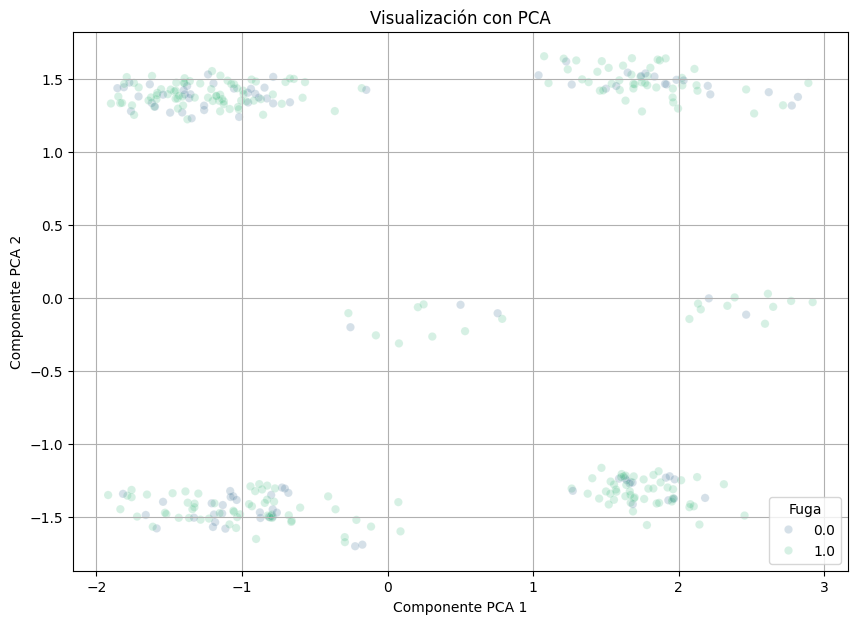

In [218]:
print("\nResultados de PCA:")
display(pca_df.head())

# Visualizar resultados de PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', hue='Fuga', data=pca_df, palette='viridis', alpha = 0.2)
plt.title('Visualización con PCA')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.grid(True)
plt.show()

Ahora haresmos lo mismo pero con el ordinal encodede dataframe en lugar de one hot

In [219]:
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_processed_scaled_array = scaler.fit_transform(train_df_ordinal_encoded)

# Create a DataFrame with the scaled data
df_processed_OE = pd.DataFrame(df_processed_scaled_array, columns=train_df_ordinal_encoded.columns)

# Display the first few rows of the scaled DataFrame
display(df_processed_OE.head())

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender,Subscription Type,Contract Length
0,-1.070635,1.242343,1.163786,1.112120,-1.132736,-2.876199,0.173218,-1.294065,-0.030399,1.043703
1,0.415562,1.650238,0.928307,-0.159294,-1.132736,-0.680103,-1.015411,0.772759,-1.265646,0.000165
2,0.601336,0.776176,-0.484564,1.535925,2.700827,-0.599880,0.529806,-1.294065,-0.030399,0.000165
3,1.808870,-1.438114,0.692829,0.688316,-1.416703,0.448028,0.529806,0.772759,1.204849,1.043703
4,-0.699085,-1.088489,0.692829,3.231144,0.997021,1.149977,-0.421097,0.772759,-0.030399,-1.043372



Resultados de PCA:


,PCA Component 1,PCA Component 2,Fuga
0,1.311500,-0.787876,NaN
1,-0.401873,-0.219354,NaN
2,2.592295,-0.489894,NaN
3,0.615919,0.729201,NaN
4,1.408788,0.177706,NaN


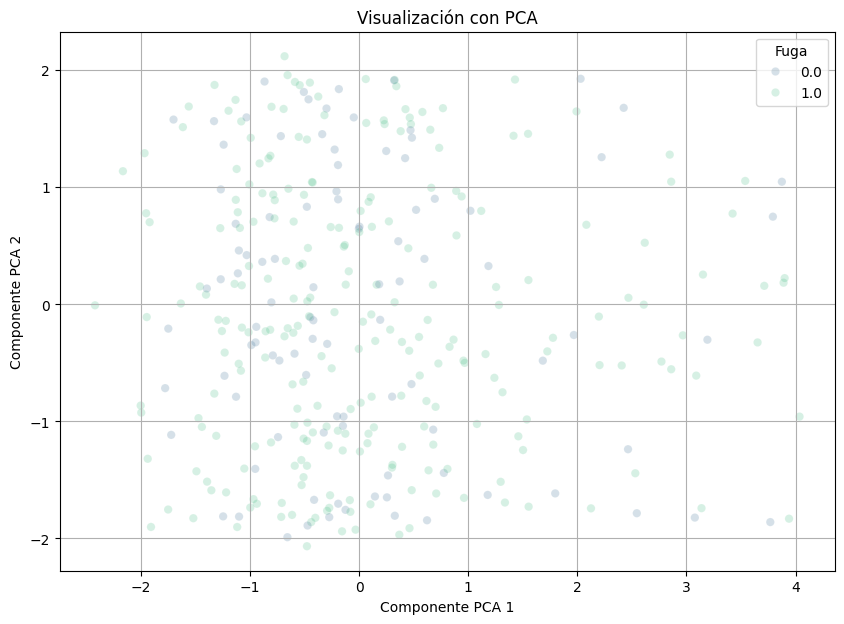

In [220]:
# Aplicar PCA para reducción de dimensiones a 2 componentes
pca = PCA(n_components=2)
pca_results = pca.fit_transform(df_processed_OE)

pca_df = pd.DataFrame(data=pca_results, columns=['PCA Component 1', 'PCA Component 2'])
pca_df['Fuga'] = lables_df['Churn']

print("\nResultados de PCA:")
display(pca_df.head())

# Visualizar resultados de PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA Component 1', y='PCA Component 2', hue='Fuga', data=pca_df, palette='viridis', alpha = 0.2)
plt.title('Visualización con PCA')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.grid(True)
plt.show()

#### T-SNE

Versión One Hot

In [221]:
# Aplicar t-SNE para reducción de dimensiones a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_processed)

tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE Component 1', 'TSNE Component 2'])
tsne_df['Fuga'] = lables_df['Churn']

print("\nResultados de t-SNE:")
display(tsne_df.head())

# Visualizar resultados de t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE Component 1', y='TSNE Component 2', hue='Fuga', data=tsne_df, palette='viridis')
plt.title('Visualización con t-SNE')
plt.xlabel('Componente TSNE 1')
plt.ylabel('Componente TSNE 2')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

Versión Ordinal Encoder

In [ ]:
# Aplicar t-SNE para reducción de dimensiones a 2 componentes
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_processed_OE)

tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE Component 1', 'TSNE Component 2'])
tsne_df['Fuga'] = lables_df['Churn']

print("\nResultados de t-SNE:")
display(tsne_df.head())

# Visualizar resultados de t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x='TSNE Component 1', y='TSNE Component 2', hue='Fuga', data=tsne_df, palette='viridis')
plt.title('Visualización con t-SNE')
plt.xlabel('Componente TSNE 1')
plt.ylabel('Componente TSNE 2')
plt.grid(True)
plt.show()

#### Autoencoders


Autoencoder con one hot encoder

/tmp/ipython-input-810714044.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(df_processed_tensor, dtype=torch.float32),
/tmp/ipython-input-810714044.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(df_processed_tensor, dtype=torch.float32))


Entrenando autoencoder por 50 epochs con minibatches...
Epoch [1/50], Loss: 0.9398
Epoch [2/50], Loss: 0.7765
Epoch [3/50], Loss: 0.7176
Epoch [4/50], Loss: 0.6642
Epoch [5/50], Loss: 0.6368
Epoch [6/50], Loss: 0.6240
Epoch [7/50], Loss: 0.6149
Epoch [8/50], Loss: 0.6060
Epoch [9/50], Loss: 0.5971
Epoch [10/50], Loss: 0.5894
Epoch [11/50], Loss: 0.5839
Epoch [12/50], Loss: 0.5795
Epoch [13/50], Loss: 0.5745
Epoch [14/50], Loss: 0.5690
Epoch [15/50], Loss: 0.5651
Epoch [16/50], Loss: 0.5618
Epoch [17/50], Loss: 0.5588
Epoch [18/50], Loss: 0.5562
Epoch [19/50], Loss: 0.5538
Epoch [20/50], Loss: 0.5516
Epoch [21/50], Loss: 0.5496
Epoch [22/50], Loss: 0.5481
Epoch [23/50], Loss: 0.5464
Epoch [24/50], Loss: 0.5451
Epoch [25/50], Loss: 0.5439
Epoch [26/50], Loss: 0.5428
Epoch [27/50], Loss: 0.5418
Epoch [28/50], Loss: 0.5413
Epoch [29/50], Loss: 0.5404
Epoch [30/50], Loss: 0.5398
Epoch [31/50], Loss: 0.5393
Epoch [32/50], Loss: 0.5386
Epoch [33/50], Loss: 0.5382
Epoch [34/50], Loss: 0.5378
E

,Latent Component 1,Latent Component 2,Fuga
0,-5.147786,10.867861,NaN
1,18.837370,22.382233,NaN
2,-6.863275,15.081145,NaN
3,9.620440,13.865137,NaN
4,19.939939,5.414737,NaN


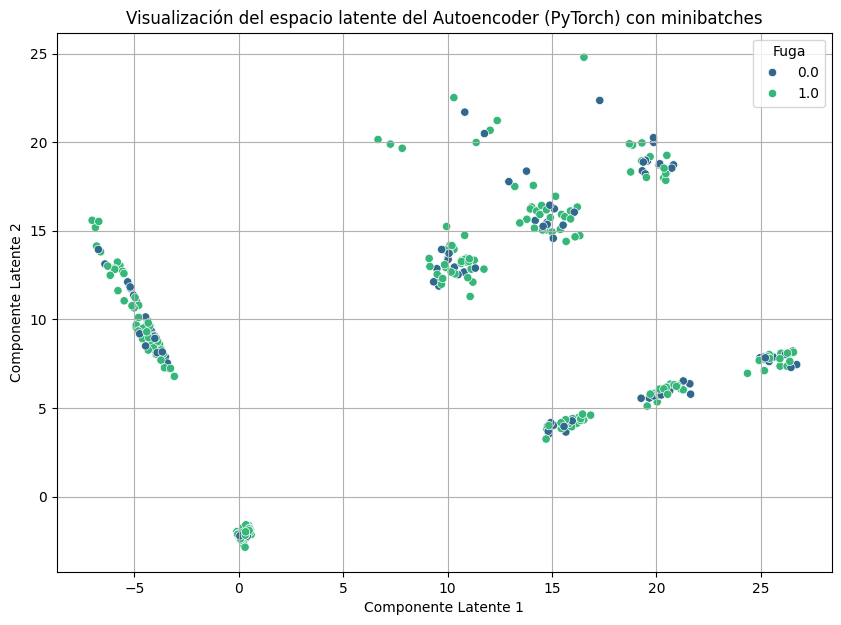

In [223]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convertir el DataFrame a un tensor de PyTorch
df_processed_tensor = torch.tensor(df_processed.values, dtype=torch.float32)

# Definir el modelo del Autoencoder en PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4),
            nn.ReLU(),
            nn.Linear(4, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Instanciar el modelo
input_dim = df_processed.shape[1]
latent_dim = 2
model = Autoencoder(input_dim, latent_dim)

# Definir la función de pérdida y el optimizador
ae_loss = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Crear un TensorDataset
train_dataset = TensorDataset(torch.tensor(df_processed_tensor, dtype=torch.float32),
                                  torch.tensor(df_processed_tensor, dtype=torch.float32))

# Crear un DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Entrenar el autoencoder con DataLoader
num_epochs = 50

# Poner el modelo en modo de entrenamiento
model.train()

# Ciclo de entrenamiento
print(f"Entrenando autoencoder por {num_epochs} epochs con minibatches...")
for epoch in range(num_epochs):
    # Inicializar lista para guardar el loss
    running_loss = []

    # Ejecutar mini-batch loop
    for batch in train_loader:
        # Separar inputs y labels
        inputs, labels = batch

        # Forward pass
        outputs, encoded = model(inputs)

        # Loss computation
        loss = ae_loss(outputs, inputs)

        # Backpropagation
        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Save current loss
        running_loss.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(running_loss):.4f}')

print("Entrenamiento del autoencoder con PyTorch completado.")

# Obtener la representación en el espacio latente
model.eval() # Cambiar a modo de evaluación
with torch.no_grad():
    latent_space_representation = model.encoder(df_processed_tensor).numpy()

# Crear un DataFrame con la representación del espacio latente y la categoría original
latent_df = pd.DataFrame(data=latent_space_representation, columns=['Latent Component 1', 'Latent Component 2'])
latent_df['Fuga'] = lables_df['Churn']

print("\nResultados del Autoencoder en el espacio latente (PyTorch):")
display(latent_df.head())

# Visualizar el espacio latente
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Latent Component 1', y='Latent Component 2', hue='Fuga', data=latent_df, palette='viridis', alpha = 0.3)
plt.title('Visualización del espacio latente del Autoencoder (PyTorch) con minibatches')
plt.xlabel('Componente Latente 1')
plt.ylabel('Componente Latente 2')
plt.grid(True)
plt.show()

### Outlier Detection